# 環境の設定

In [1]:
from blindcliftwalk import BlindCliftwalk

# ゴールまでの距離
nb_step = 20
#nb_step = 10

# ゴールの数
nb_goals = 3
#nb_goals = 1

env = BlindCliftwalk(nb_step, nb_goals)

In [2]:
import numpy as np

np.random.seed(seed=50)
env.set_ground_truth()
env.ground_truth

array([[2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

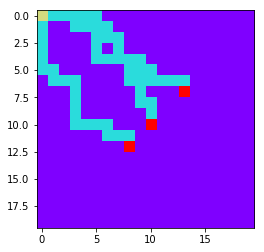

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
#plt.savefig('ground_truth.png')

# value functionをTD学習で学習する

In [4]:
import numpy as np

#  state value更新回数
mc_step = 300000
#mc_step = 3000

# 割引率
gamma = 1. - 1. / float(nb_step)

# 学習率
learning_rate = 0.25

# 考えうる状態の数はground_truthの大きさと同じ（もう少し小さいが、面倒なので同じとする）
value_table = np.zeros_like(env.ground_truth, dtype=float)

# ゴール到達後のstate valueの保存間隔
#save_interval = 10000
save_interval = 1000

# ε-greedyのハイパーパラメータ
epsilon = 0.3

In [5]:
from tqdm import tqdm

stacked_value_table = []
isSuccessed = False

value_table = np.zeros_like(value_table) # state valueの初期化（念のためループ直前でも初期化する）
#rnd = np.random.normal(loc=0., scale=0.1, size=value_table.shape)
#value_table = rnd*(rnd>0)*(rnd<0.3)
try:
    count = 0
    for i in tqdm(range(mc_step)):
        # 状態の初期化
        current_state  = np.zeros(2, dtype=int)

        status = 0
        while status >= 0:
            # state valueが最大となる行動を取る（まだ遷移させない）。
            if np.random.random(1) > epsilon:
                action_candidates = [[0,1], [1,0]]
                next_state_1, _, _ = env.do_action(current_state, action_candidates[0])
                next_state_2, _, _ = env.do_action(current_state, action_candidates[1])
                v1 = value_table[next_state_1[0], next_state_1[1]]
                v2 = value_table[next_state_2[0], next_state_2[1]]
                v_candidates = np.array([v1,v2])
                action = action_candidates[v_candidates.argmax()]
            else:
                action = env.random_action()
                
            # 行動に対する報酬と遷移後の状態の計算
            next_state, reward, status = env.do_action(current_state, action)
            
            if status==1:
                isSuccessed = True

            if status>=0:
                # TD誤差の計算
                V_current = value_table[current_state[0], current_state[1]]
                V_next = value_table[next_state[0], next_state[1]]
                td_error = reward + gamma * V_next - V_current

                # state valueの更新
                value_table[current_state[0], current_state[1]] = V_current + learning_rate * td_error

                # 状態の遷移（マス目の移動）
                current_state = next_state
                
                if isSuccessed:
#                if True:
                    count += 1
                    if count==save_interval:
                        stacked_value_table.append(np.copy(value_table))
                        count = 0
            
except Exception:
    pass

100%|██████████| 300000/300000 [00:44<00:00, 6808.88it/s]


# 学習過程の可視化
- TD学習では一度ゴールまでたどり着くとその後常にstate valueが更新される。

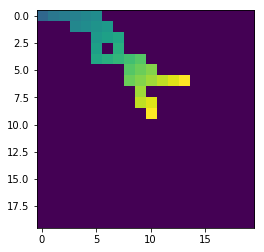

In [6]:
plt.imshow(value_table, interpolation='nearest')
plt.clim(0,1)

In [7]:
len(stacked_value_table)

1515

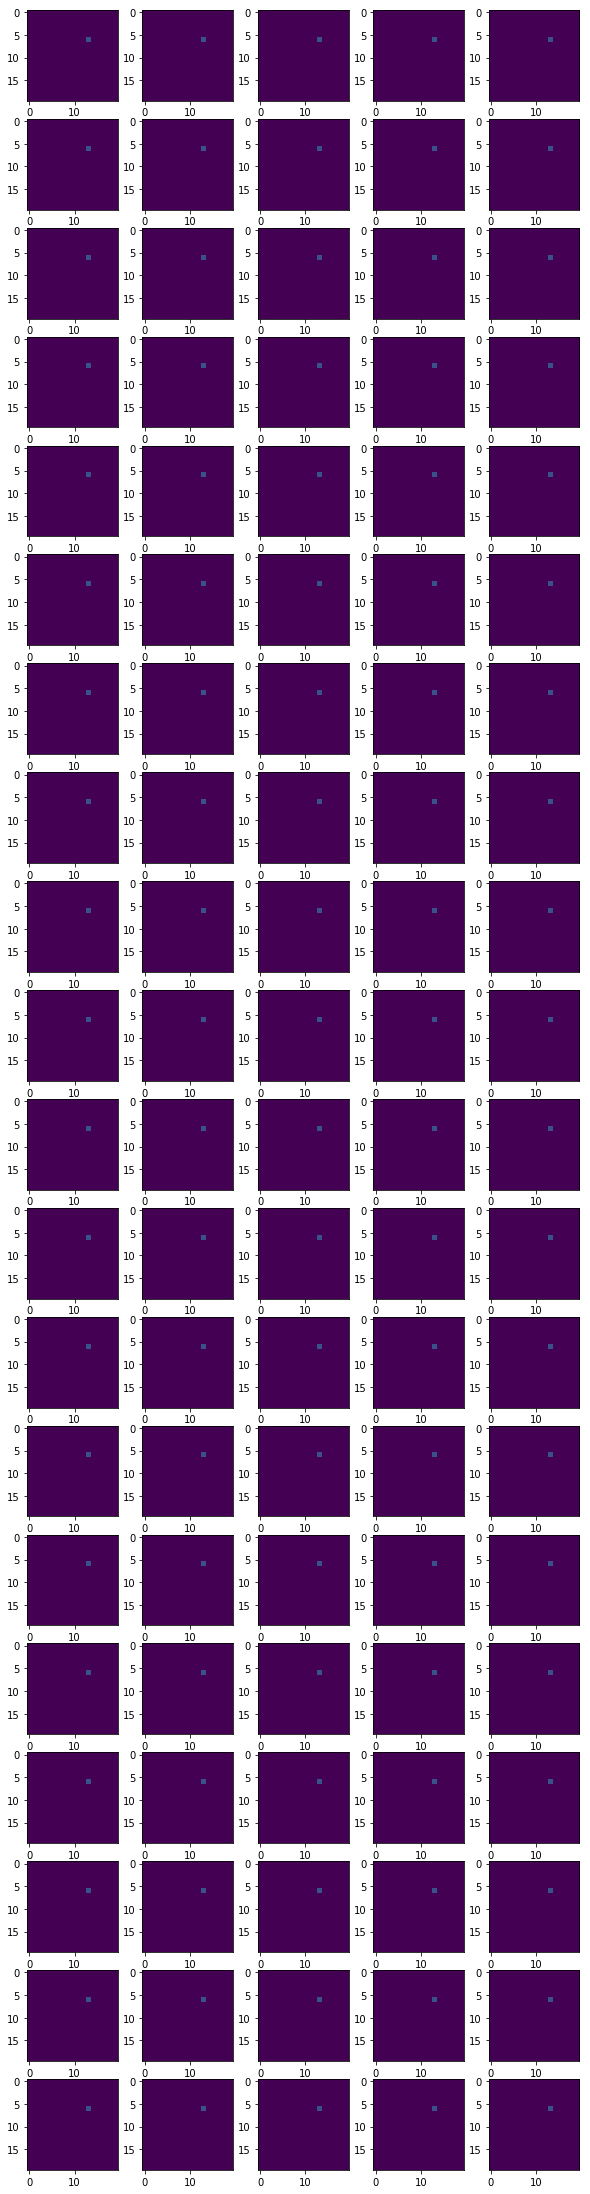

In [8]:
if isSuccessed:
    nb_show = 100
    nb = 0
    plt.figure(figsize=(10,10*int(len(stacked_value_table[:nb_show])+1)/5.))
    for v in stacked_value_table[:nb_show]:
        nb += 1
        plt.subplot(int(len(stacked_value_table[:nb_show])+1),5,nb)
        plt.imshow(v, interpolation='nearest')
        plt.clim(0,1)

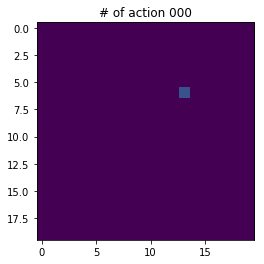

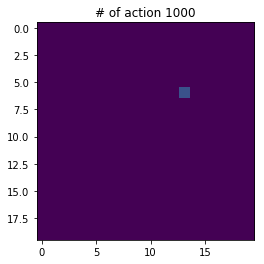

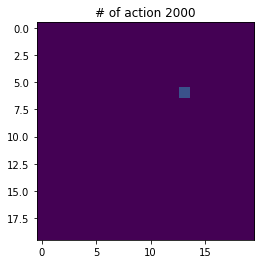

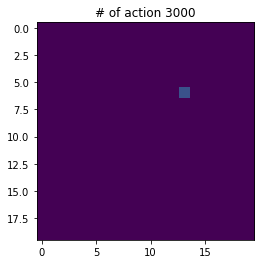

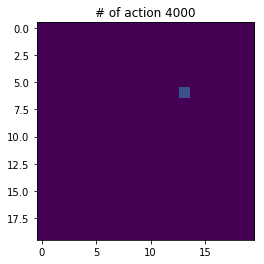

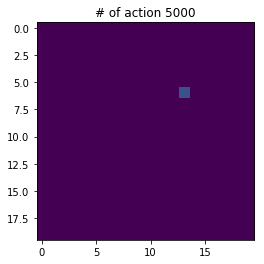

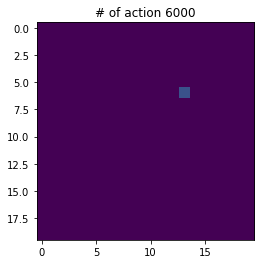

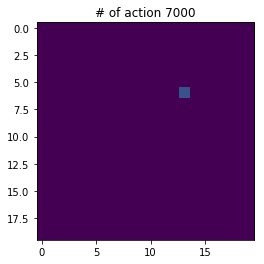

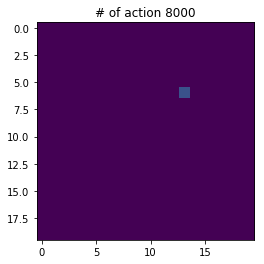

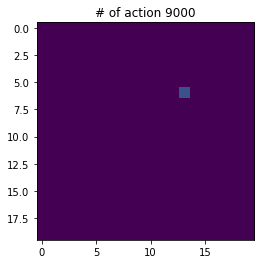

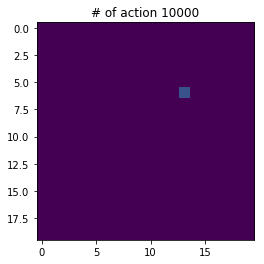

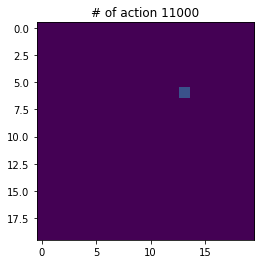

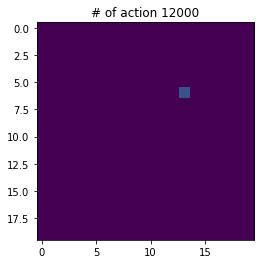

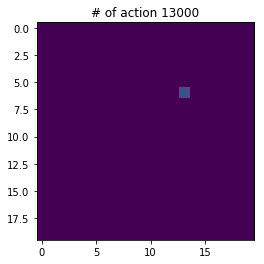

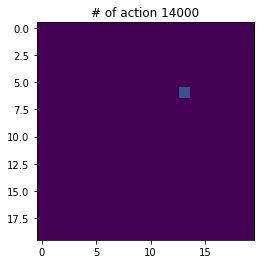

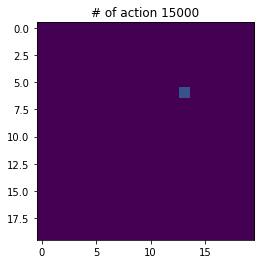

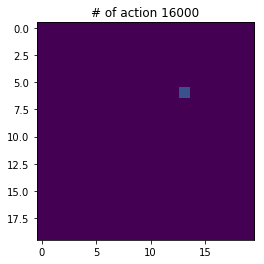

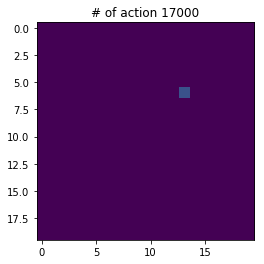

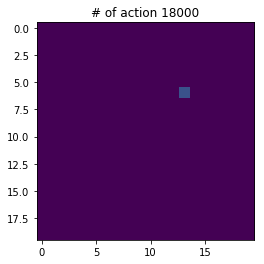

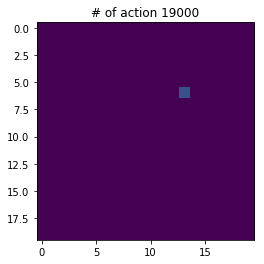

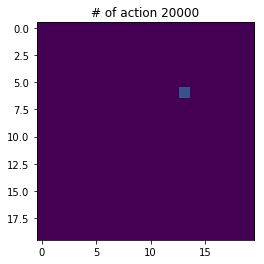

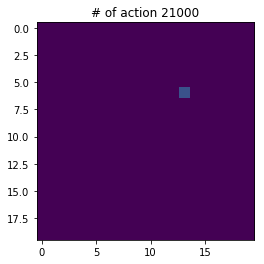

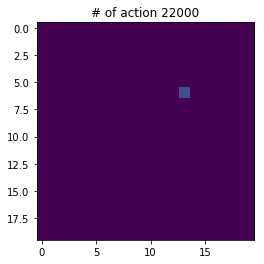

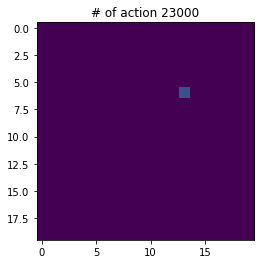

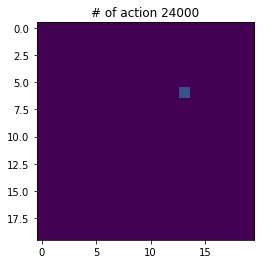

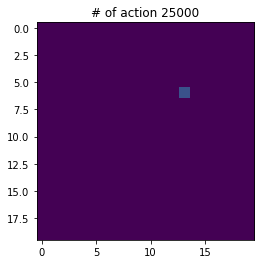

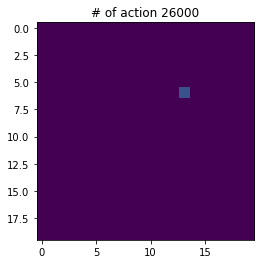

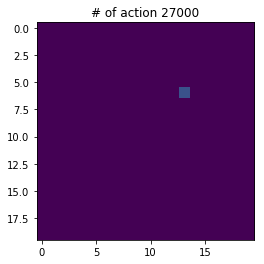

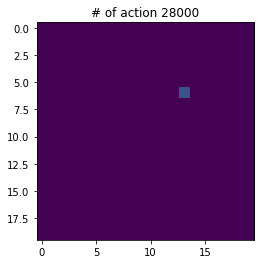

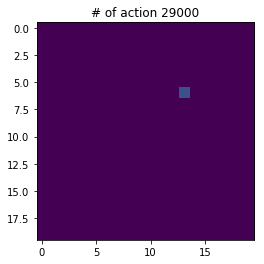

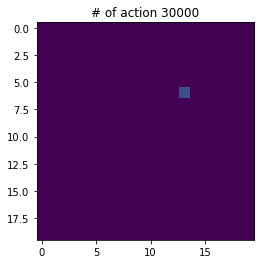

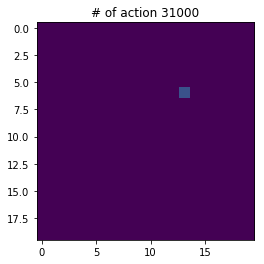

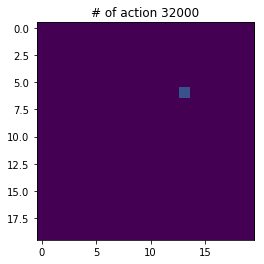

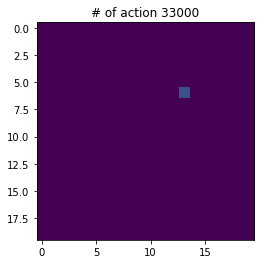

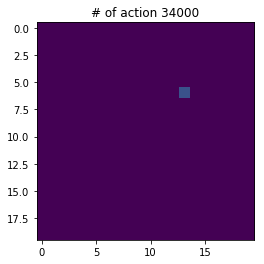

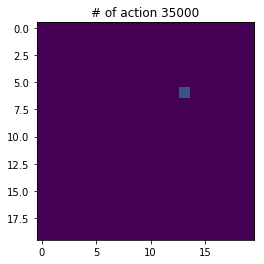

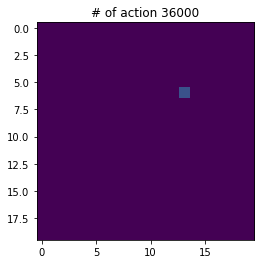

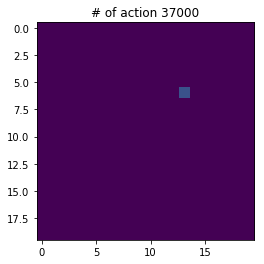

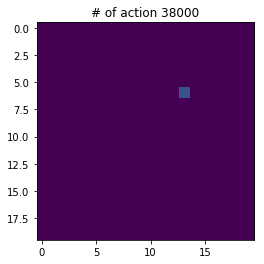

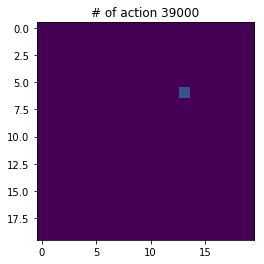

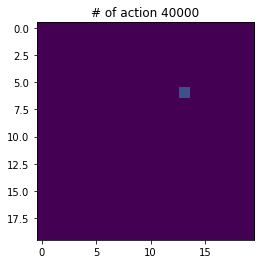

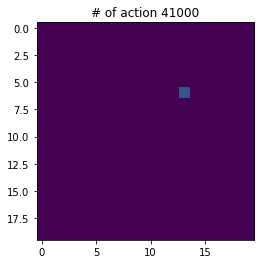

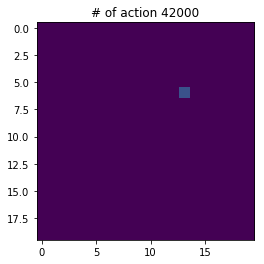

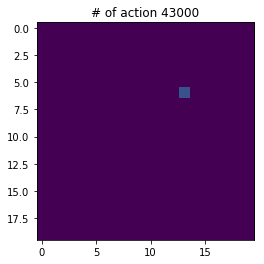

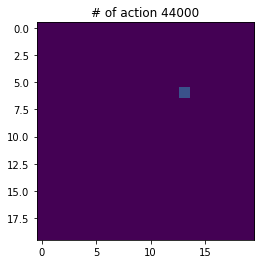

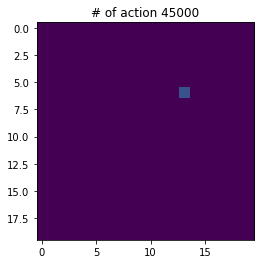

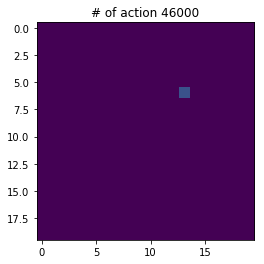

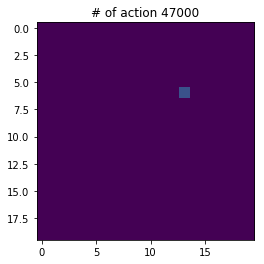

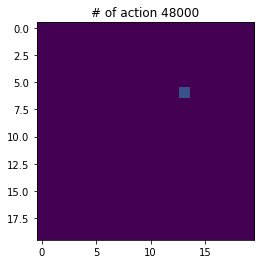

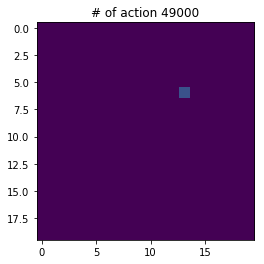

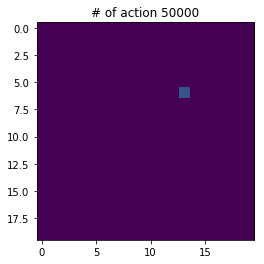

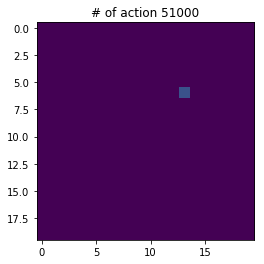

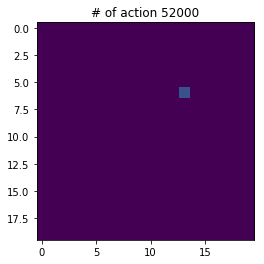

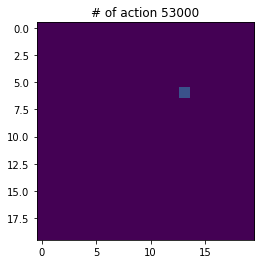

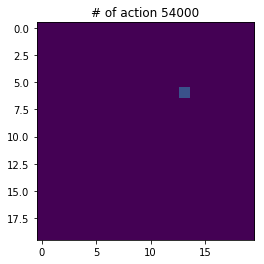

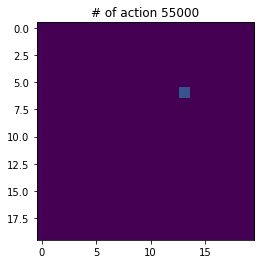

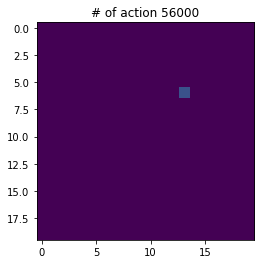

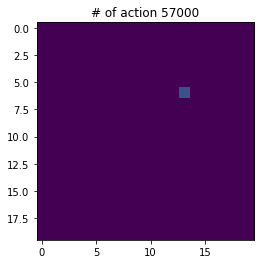

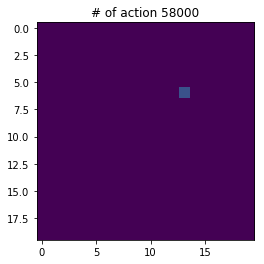

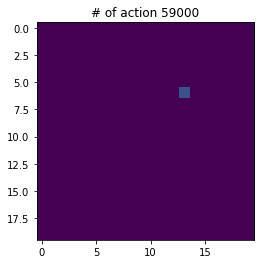

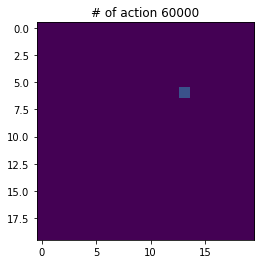

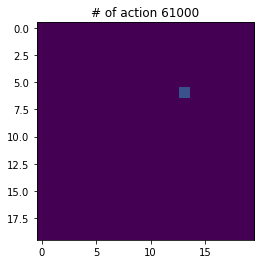

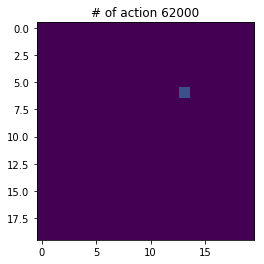

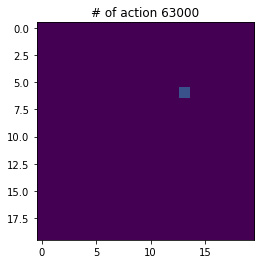

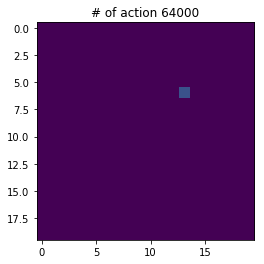

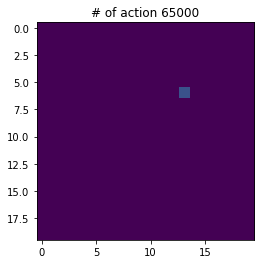

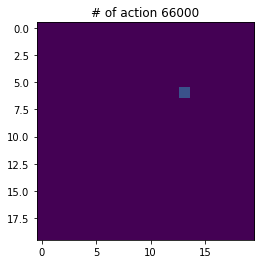

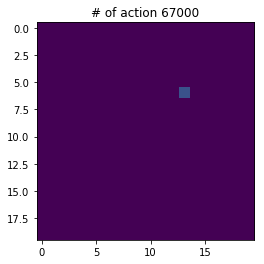

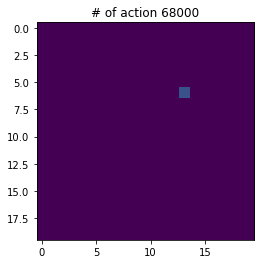

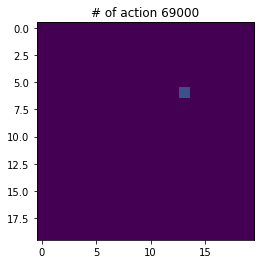

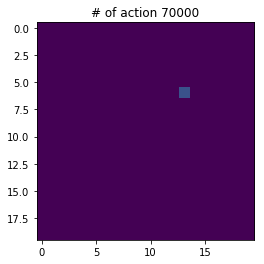

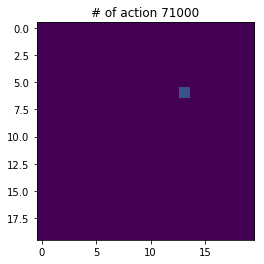

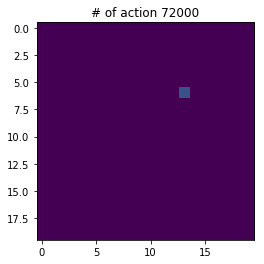

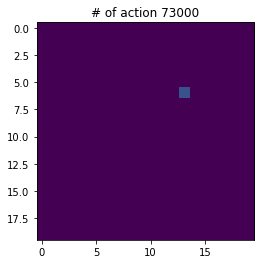

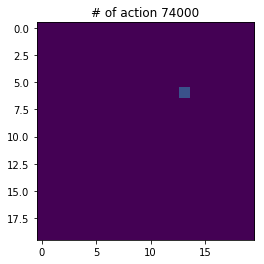

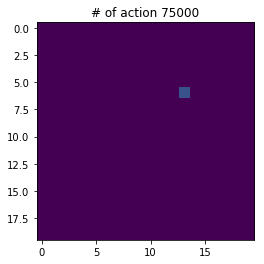

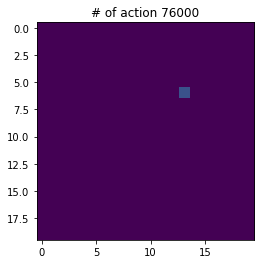

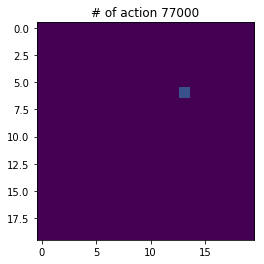

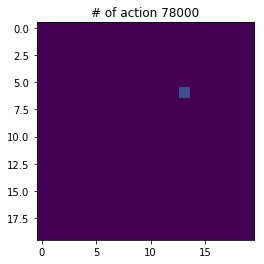

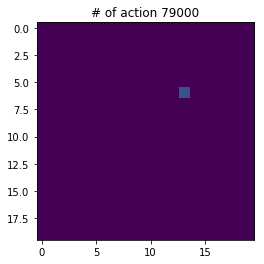

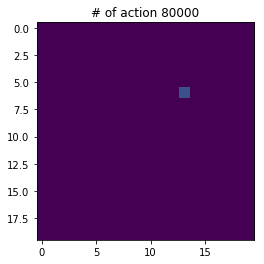

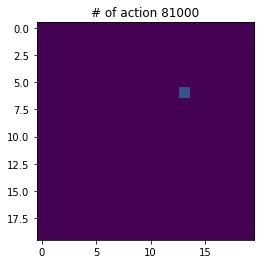

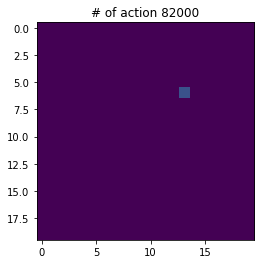

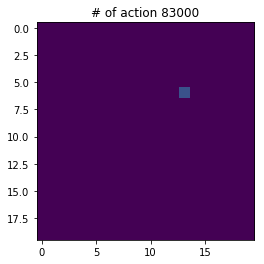

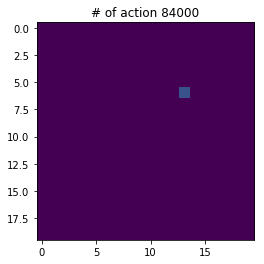

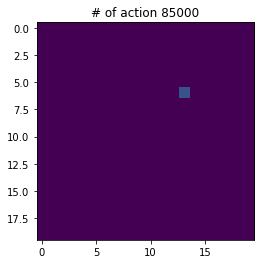

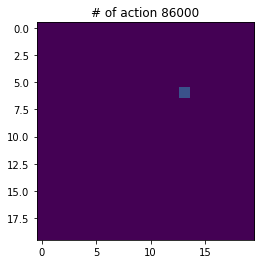

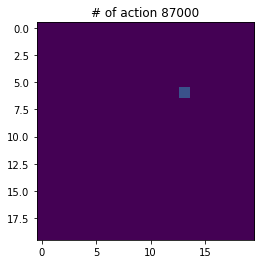

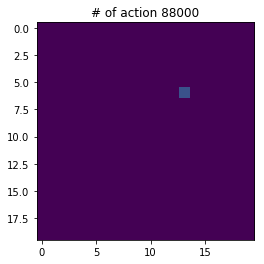

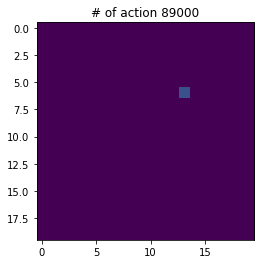

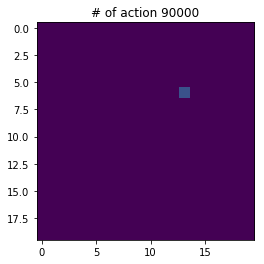

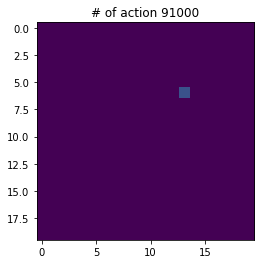

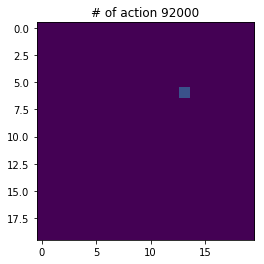

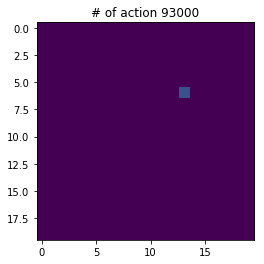

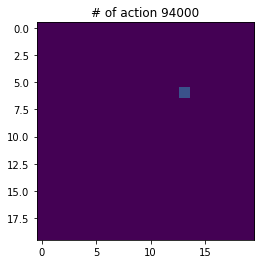

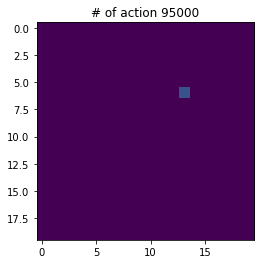

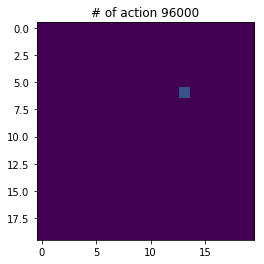

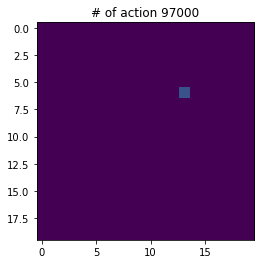

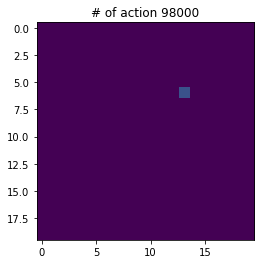

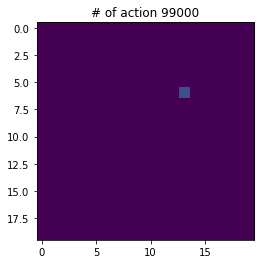

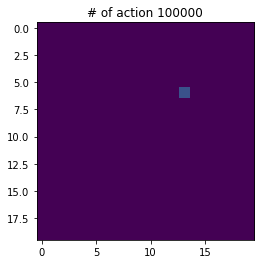

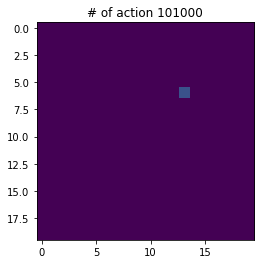

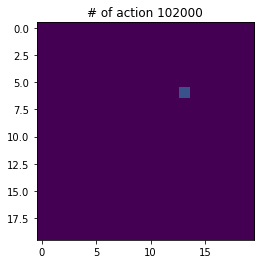

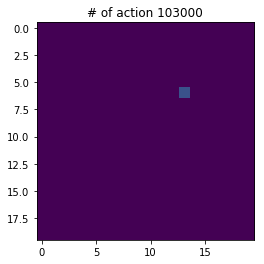

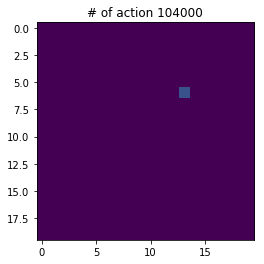

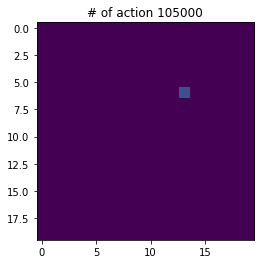

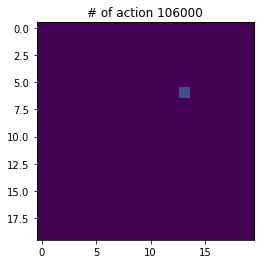

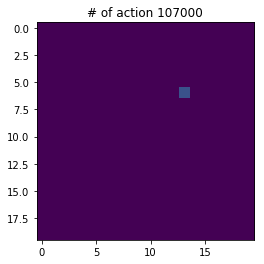

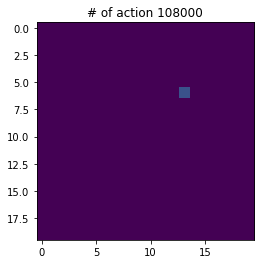

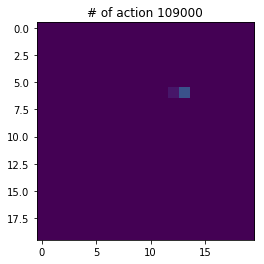

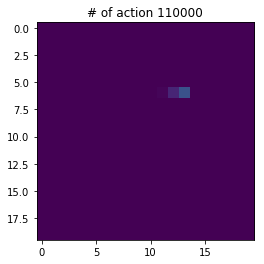

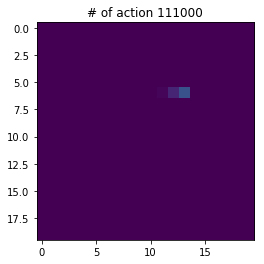

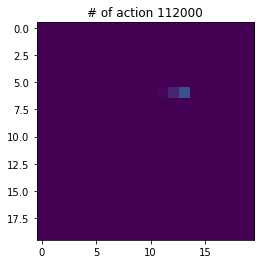

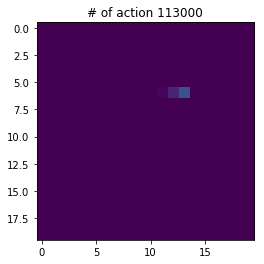

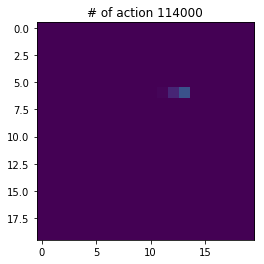

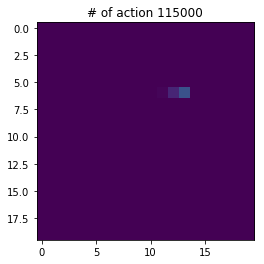

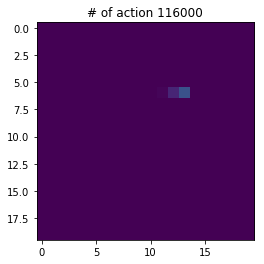

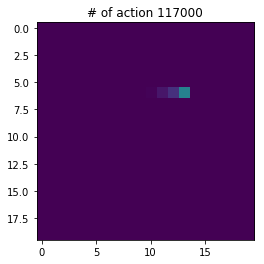

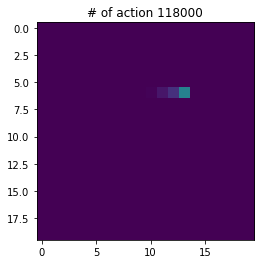

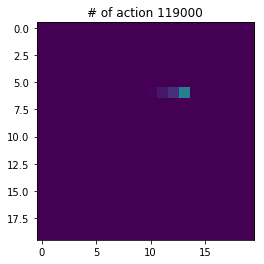

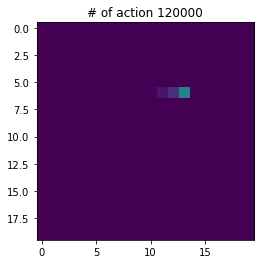

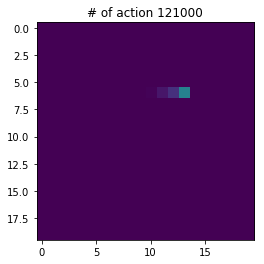

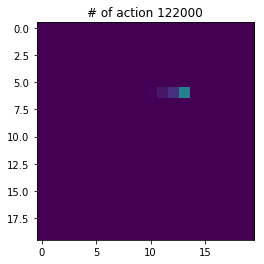

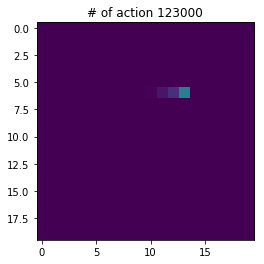

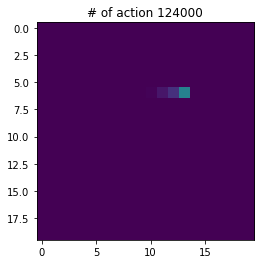

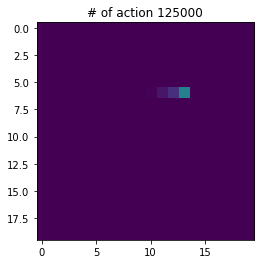

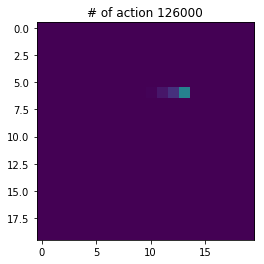

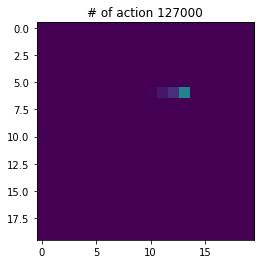

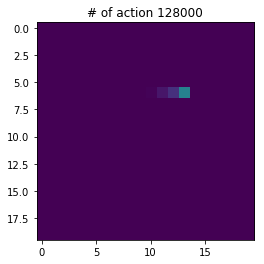

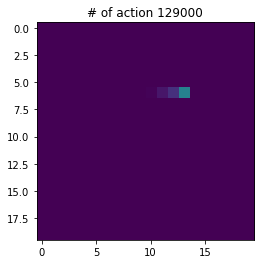

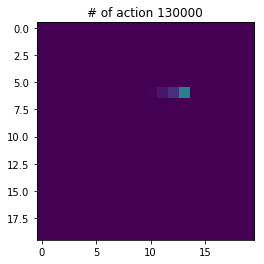

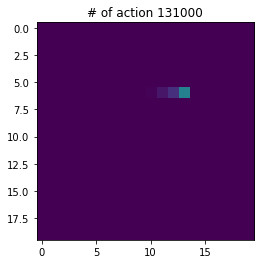

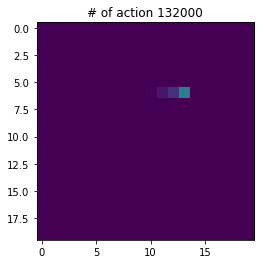

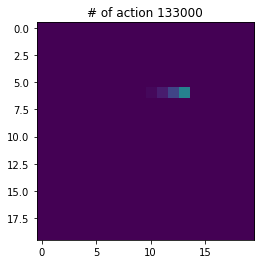

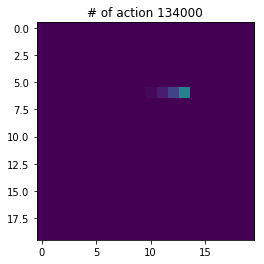

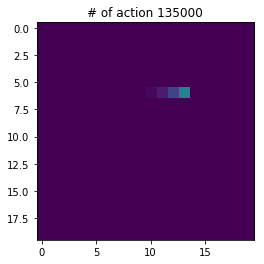

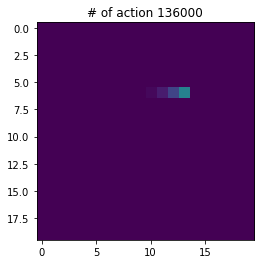

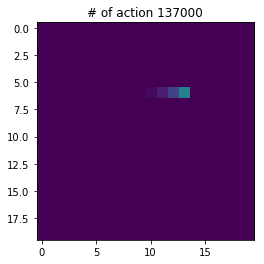

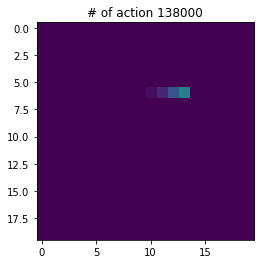

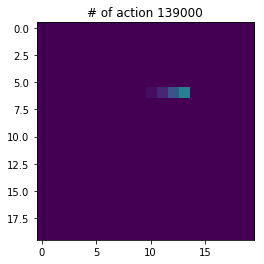

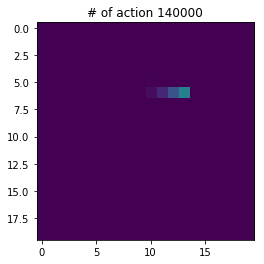

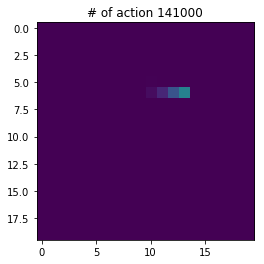

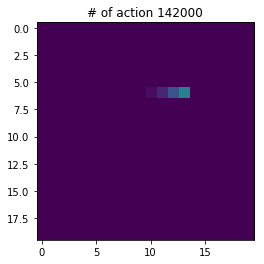

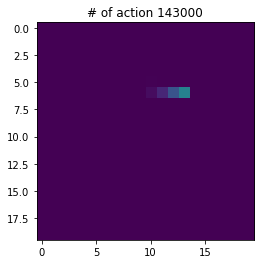

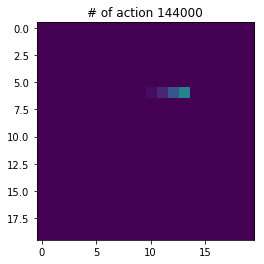

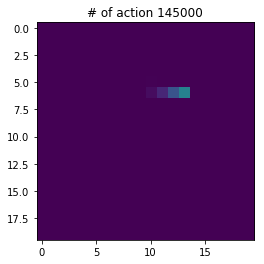

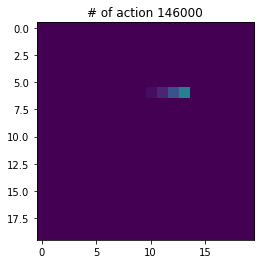

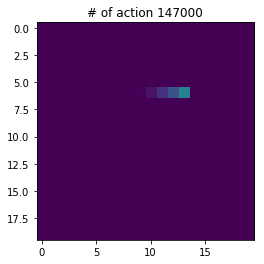

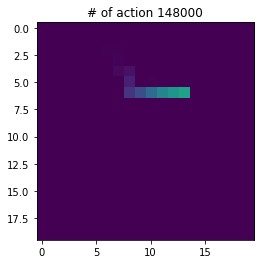

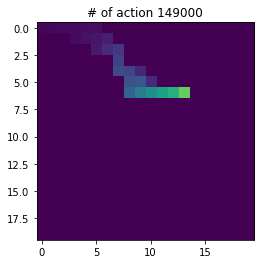

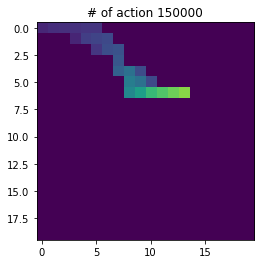

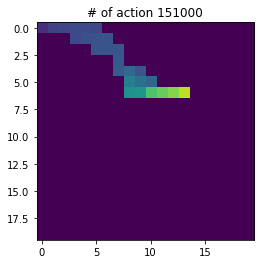

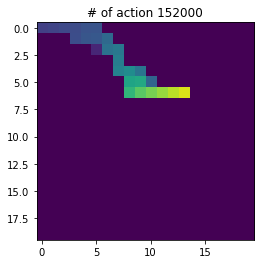

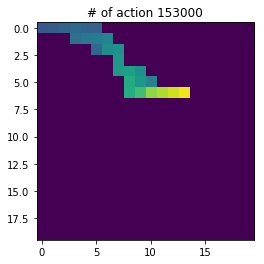

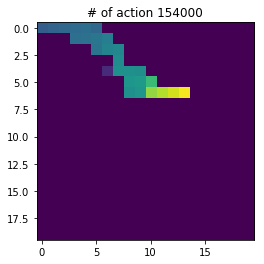

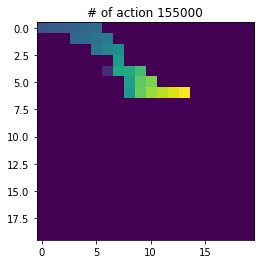

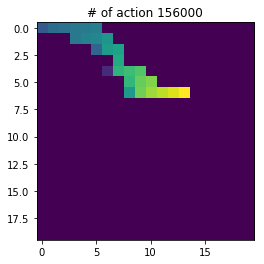

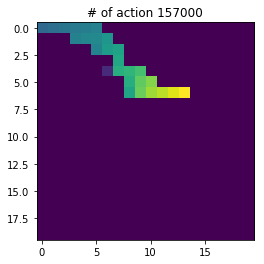

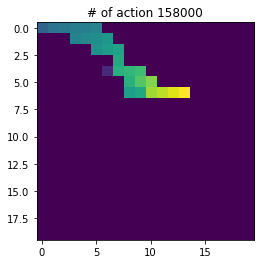

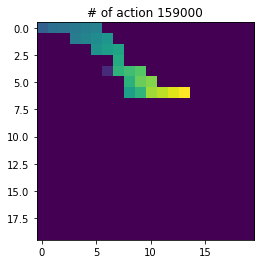

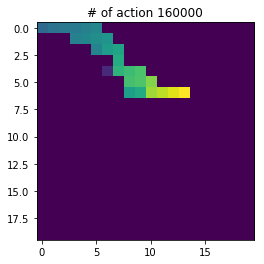

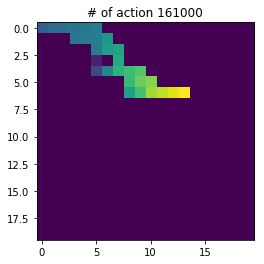

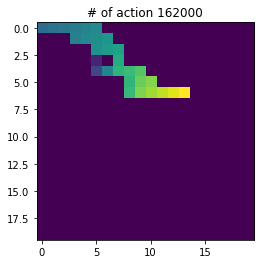

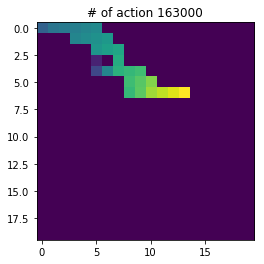

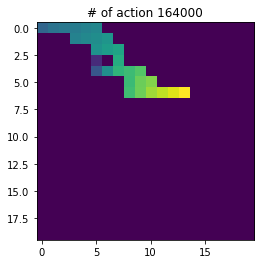

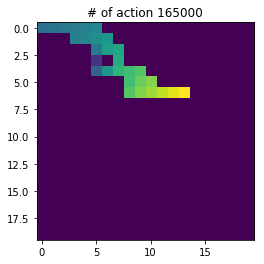

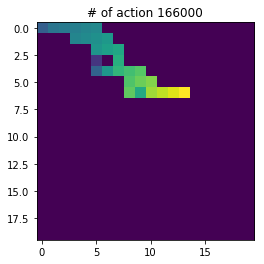

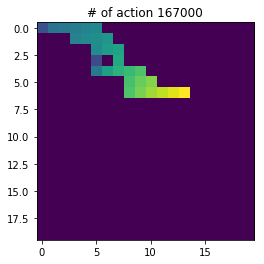

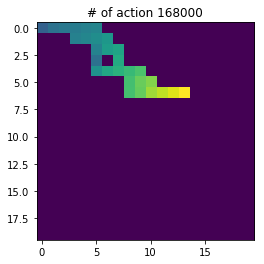

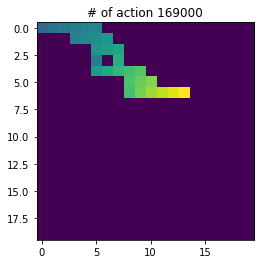

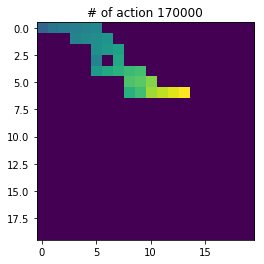

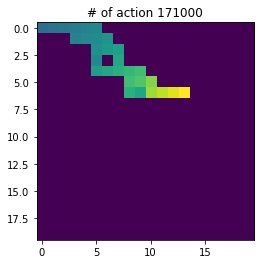

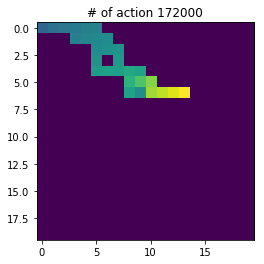

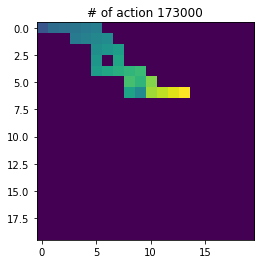

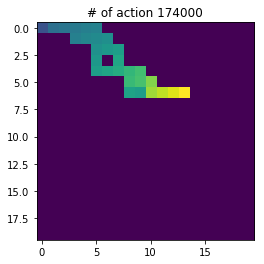

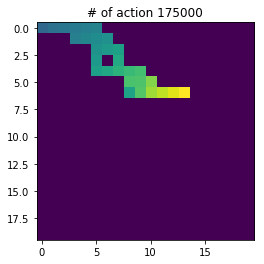

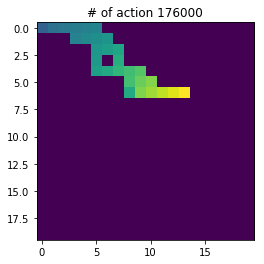

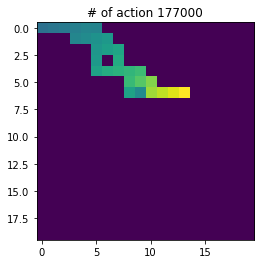

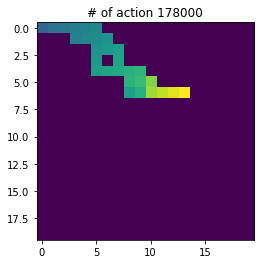

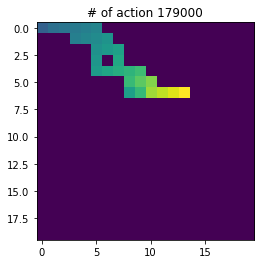

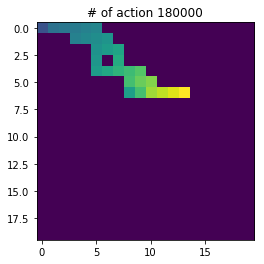

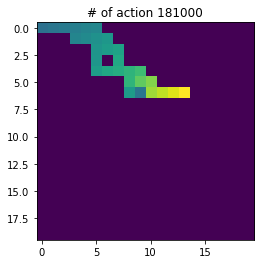

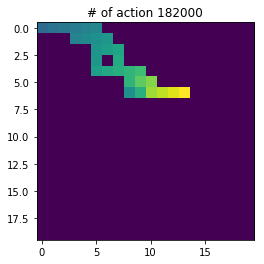

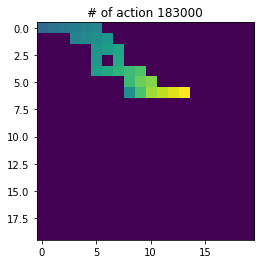

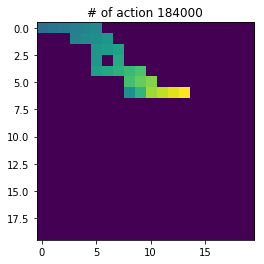

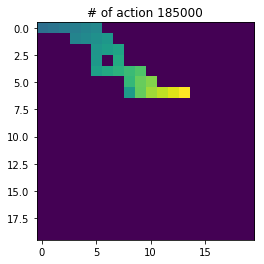

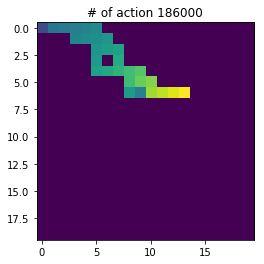

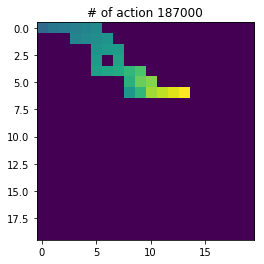

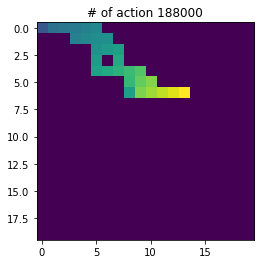

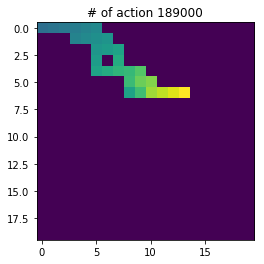

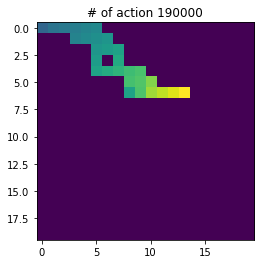

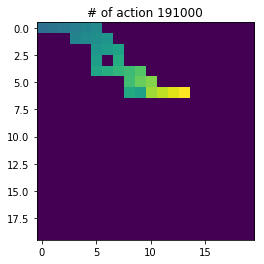

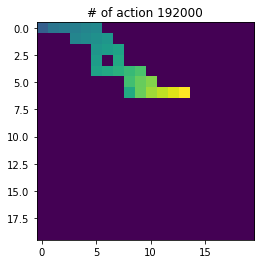

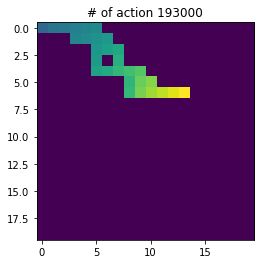

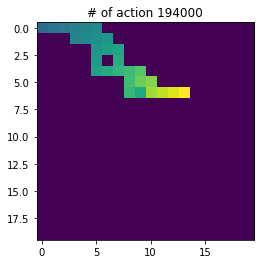

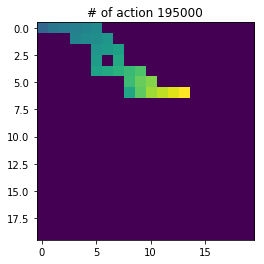

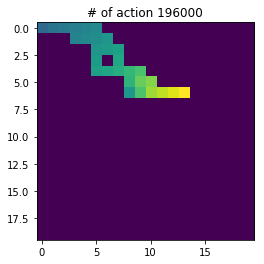

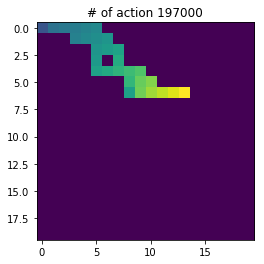

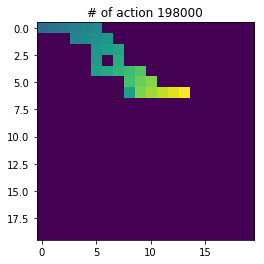

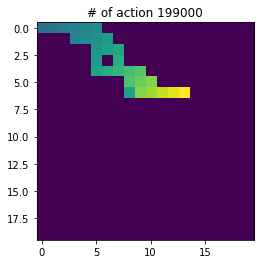

In [9]:
for i,v in enumerate(stacked_value_table[:200]):
    plt.imshow(v, interpolation='nearest')
    plt.clim(0,1)
    plt.title('# of action '+str(i*save_interval).zfill(3))
    plt.savefig('TD_iter_'+str(i).zfill(4)+'.png')
    plt.show()